### Predicting Daily Bitcoin Stock

#### Assignment Specs:
* You need to explore multiple recurrent neural network models to solve this problem. 
* The dataset includes multiple time series. You may choose which one you want to model.

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from plotnine import ggplot, geom_point, geom_smooth, aes, stat_smooth, geom_line, xlim, ylim

2024-05-20 09:22:19.795341: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back), 0]
      dataX.append(a)
      dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
data = pd.read_csv('/Users/ruojiakuang/Desktop/GSB 545 Advanced ML/Lab 5 RNN/dc.csv')
data.head()

,Unnamed: 0,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
0,2021-01-30,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
1,2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2,2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
3,2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
4,2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972


We will use volume variable to predict daily bitcoin stock. 

In [7]:
data2 = data[["volume"]].iloc[::-1]
data2.head()

,volume
999,33787
998,25533
997,25673
996,25055
995,48227


### Modeling 

#### Model 1: look back = 2, 80/20 split, LSTM(4)

In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data2 = scaler.fit_transform(data2)

train_size = int(len(data2) * 0.8)
test_size = len(data2) - train_size
train, test = data2[0:train_size], data2[train_size:len(data2)]
print(len(train), len(test))

800 200


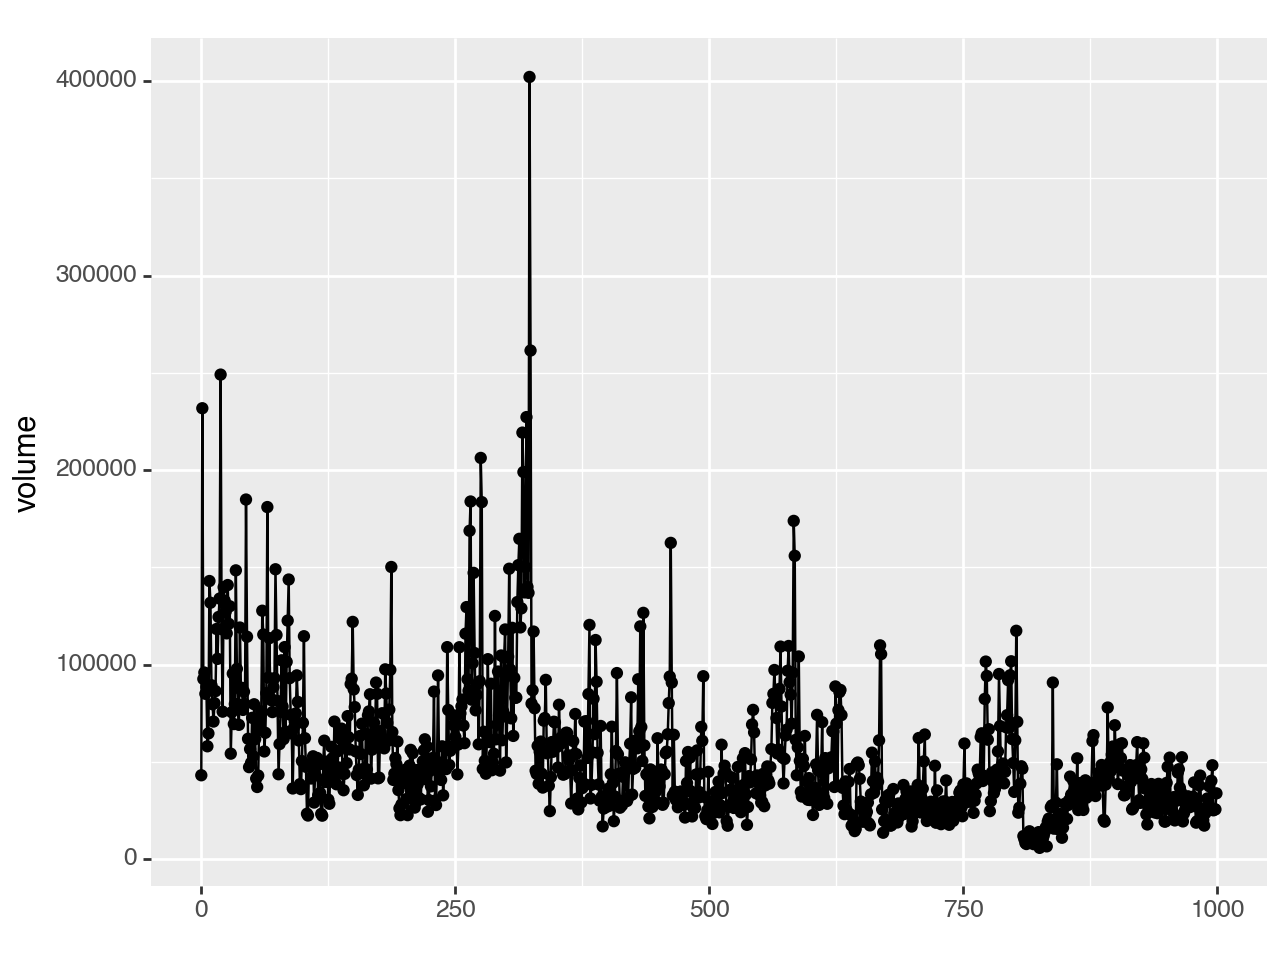

<Figure Size: (640 x 480)>

In [9]:
(ggplot(data, aes(range(len(data)), "volume"))
 + geom_point()
 + geom_line())

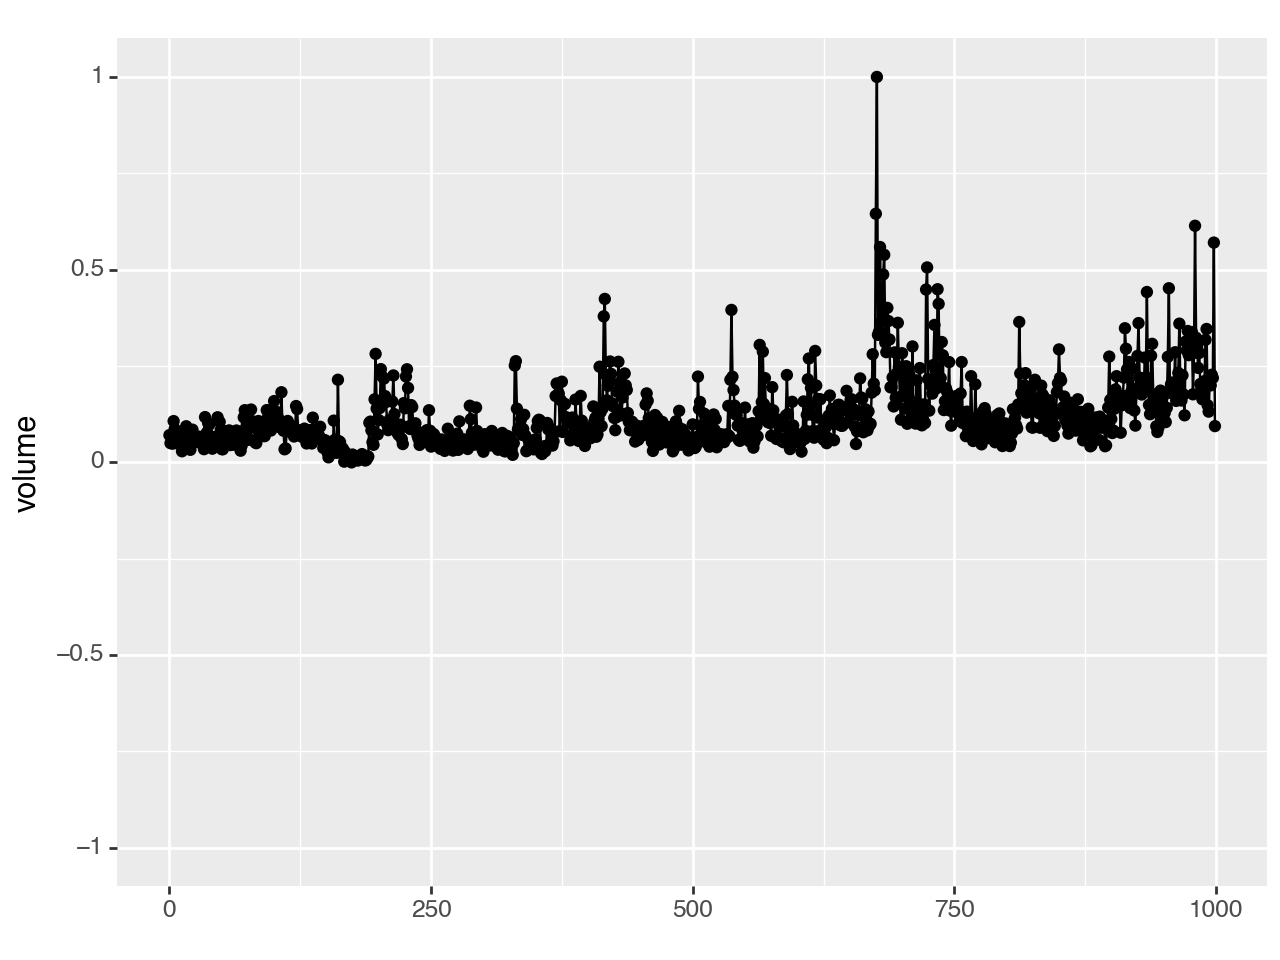

<Figure Size: (640 x 480)>

In [10]:
data3 = pd.DataFrame(data2)
data3.columns = ["volume"]
(ggplot(data3, aes(range(len(data3)), "volume"))
 + geom_point()
 + geom_line()
 + ylim(-1, 1))

In [11]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10


/Users/ruojiakuang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


797/797 - 3s - 4ms/step - loss: 0.0068
Epoch 2/10
797/797 - 1s - 1ms/step - loss: 0.0052
Epoch 3/10
797/797 - 1s - 1ms/step - loss: 0.0045
Epoch 4/10
797/797 - 1s - 1ms/step - loss: 0.0042
Epoch 5/10
797/797 - 1s - 1ms/step - loss: 0.0040
Epoch 6/10
797/797 - 1s - 1ms/step - loss: 0.0039
Epoch 7/10
797/797 - 1s - 1ms/step - loss: 0.0038
Epoch 8/10
797/797 - 1s - 1ms/step - loss: 0.0038
Epoch 9/10
797/797 - 1s - 1ms/step - loss: 0.0037
Epoch 10/10
797/797 - 1s - 1ms/step - loss: 0.0037


In [14]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Score: 23561.00 RMSE
Test Score: 29878.04 RMSE


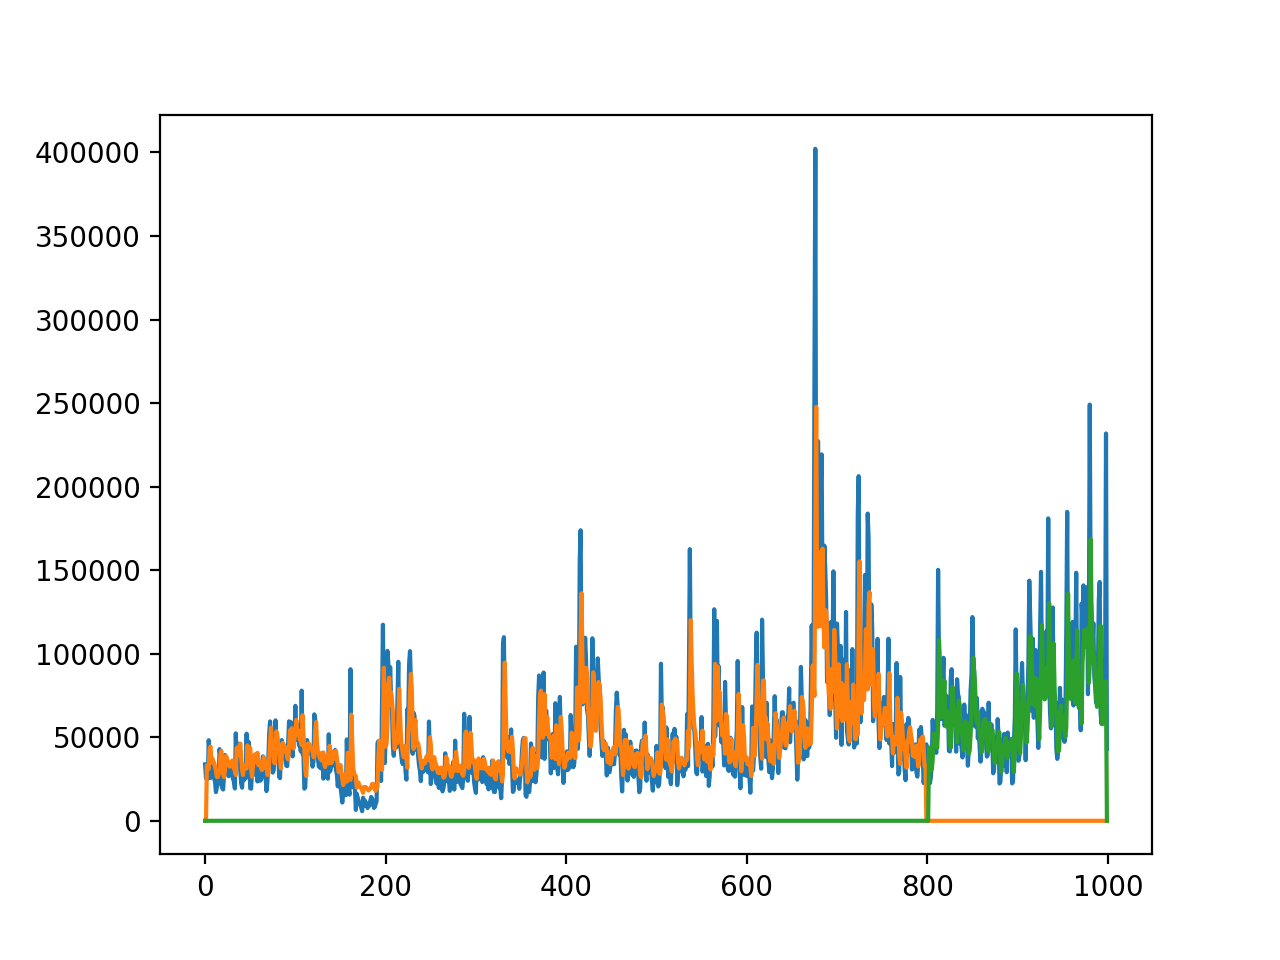

In [15]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data2)
#trainPredictPlot[:, :] = np.nan
trainPredictPlot[:, :] = 0
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data2)
#testPredictPlot[:, :] = np.nan
testPredictPlot[:, :] = 0
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data2)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [16]:
finalma = np.append(scaler.inverse_transform(data2).flatten(), trainPredictPlot.flatten())
finalma = np.append(finalma, testPredictPlot.flatten())

finallabels = np.append(["Original"]*len(trainPredictPlot), ["Train"]*len(trainPredictPlot))
finallabels = np.append(finallabels, ["Test"]*len(trainPredictPlot))

finaltime = np.append(range(len(trainPredictPlot)), range(len(trainPredictPlot)))
finaltime = np.append(finaltime, range(len(trainPredictPlot)))

results = pd.DataFrame(data = 
    {'timeindex': finaltime,
    'volume': finalma,
    'label': finallabels}
)

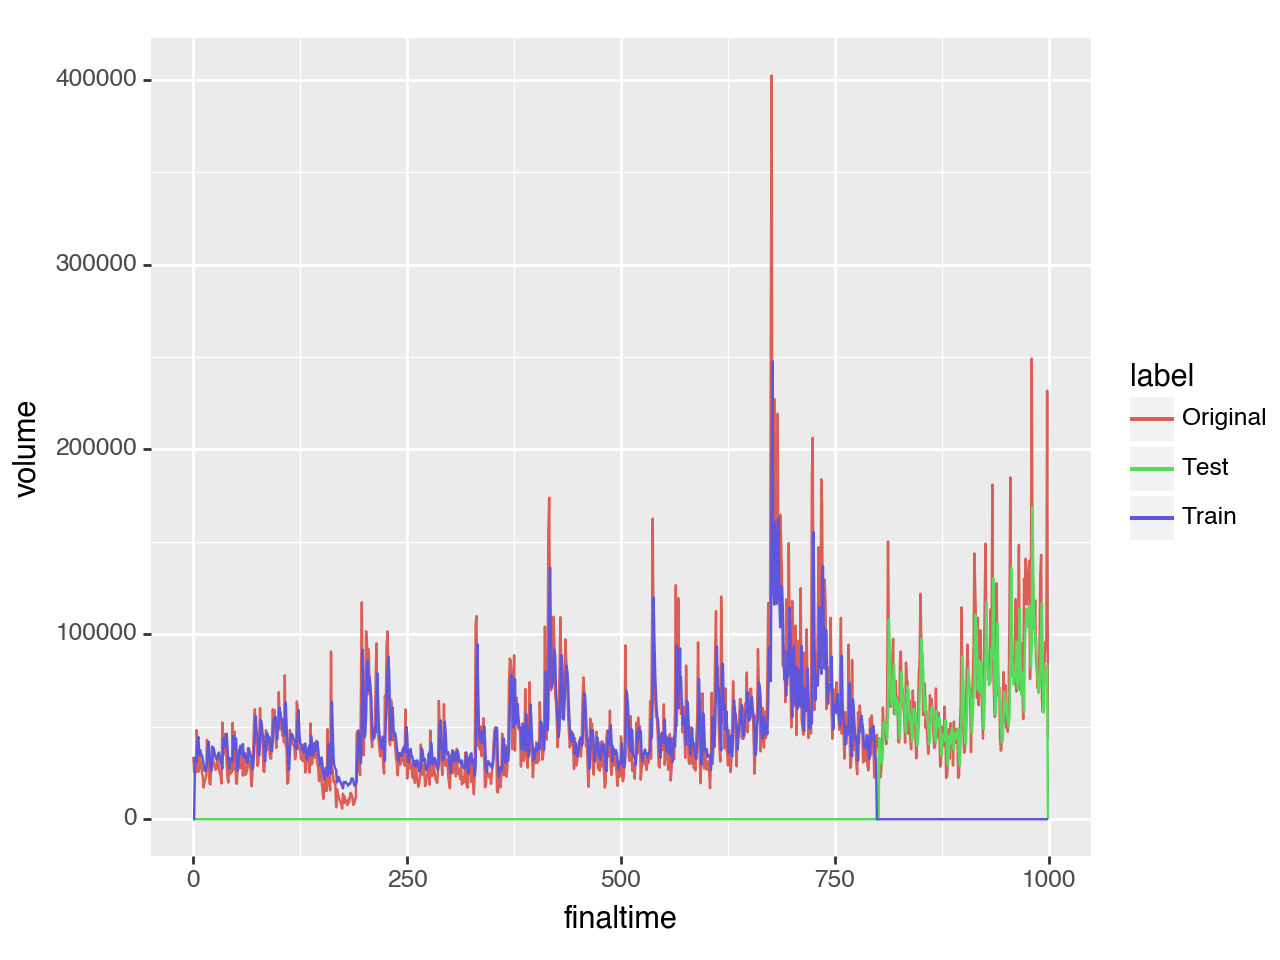

<Figure Size: (640 x 480)>

In [17]:
(ggplot(results, aes("finaltime", "volume", color = "label"))
 + geom_line())

### Model 2: look back = 3, 80/20 split, LSTM(6)

In [18]:
# change our look back from 2 to 3
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [19]:
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 1))
testX = np.reshape(testX, (testX.shape[0], look_back, 1))

In [20]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(look_back, 1)))  # Update the input_shape
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10


/Users/ruojiakuang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


796/796 - 3s - 4ms/step - loss: 0.0065
Epoch 2/10
796/796 - 1s - 1ms/step - loss: 0.0044
Epoch 3/10
796/796 - 1s - 2ms/step - loss: 0.0040
Epoch 4/10
796/796 - 1s - 1ms/step - loss: 0.0040
Epoch 5/10
796/796 - 1s - 1ms/step - loss: 0.0039
Epoch 6/10
796/796 - 1s - 1ms/step - loss: 0.0039
Epoch 7/10
796/796 - 1s - 1ms/step - loss: 0.0039
Epoch 8/10
796/796 - 1s - 2ms/step - loss: 0.0038
Epoch 9/10
796/796 - 1s - 2ms/step - loss: 0.0038
Epoch 10/10
796/796 - 1s - 1ms/step - loss: 0.0038


In [21]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train Score: 24066.00 RMSE
Test Score: 30698.64 RMSE


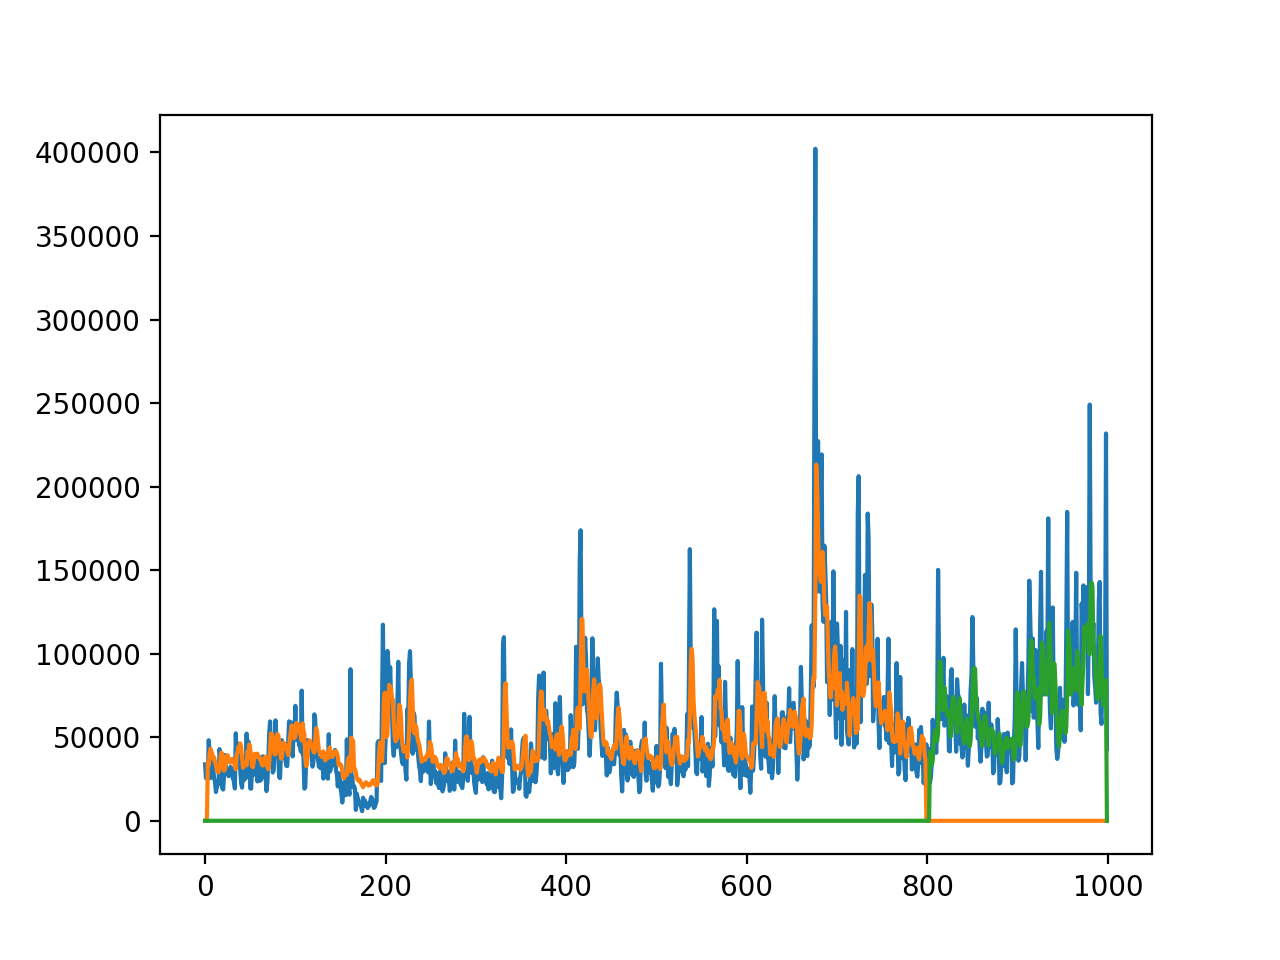

In [22]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data2)
#trainPredictPlot[:, :] = np.nan
trainPredictPlot[:, :] = 0
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data2)
#testPredictPlot[:, :] = np.nan
testPredictPlot[:, :] = 0
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data2)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [23]:
finalma = np.append(scaler.inverse_transform(data2).flatten(), trainPredictPlot.flatten())
finalma = np.append(finalma, testPredictPlot.flatten())

finallabels = np.append(["Original"]*len(trainPredictPlot), ["Train"]*len(trainPredictPlot))
finallabels = np.append(finallabels, ["Test"]*len(trainPredictPlot))

finaltime = np.append(range(len(trainPredictPlot)), range(len(trainPredictPlot)))
finaltime = np.append(finaltime, range(len(trainPredictPlot)))

results = pd.DataFrame(data = 
    {'timeindex': finaltime,
    'volume': finalma,
    'label': finallabels}
)

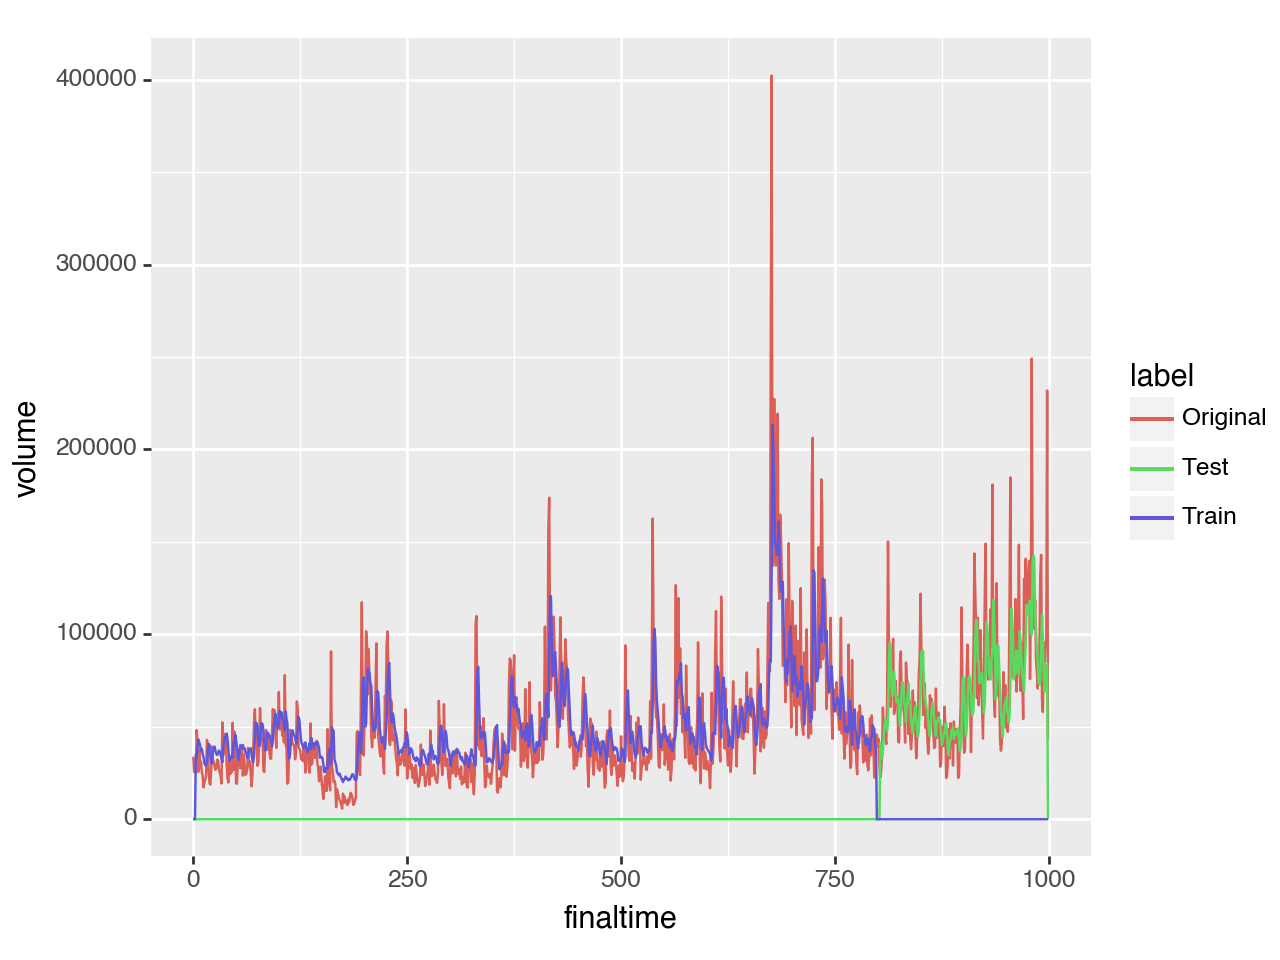

<Figure Size: (640 x 480)>

In [24]:
(ggplot(results, aes("finaltime", "volume", color = "label"))
 + geom_line())

### Model 3: look back = 4, 80/20 split, LSTM(10)

In [25]:
# change our look back from 3 to 4
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [26]:
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 1))
testX = np.reshape(testX, (testX.shape[0], look_back, 1))

In [27]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(look_back, 1)))  # Update the input_shape
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10


/Users/ruojiakuang/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


795/795 - 3s - 3ms/step - loss: 0.0056
Epoch 2/10
795/795 - 1s - 1ms/step - loss: 0.0039
Epoch 3/10
795/795 - 1s - 2ms/step - loss: 0.0039
Epoch 4/10
795/795 - 1s - 1ms/step - loss: 0.0038
Epoch 5/10
795/795 - 1s - 2ms/step - loss: 0.0037
Epoch 6/10
795/795 - 1s - 2ms/step - loss: 0.0038
Epoch 7/10
795/795 - 1s - 2ms/step - loss: 0.0037
Epoch 8/10
795/795 - 1s - 2ms/step - loss: 0.0037
Epoch 9/10
795/795 - 1s - 2ms/step - loss: 0.0036
Epoch 10/10
795/795 - 1s - 2ms/step - loss: 0.0036


In [28]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train Score: 23088.61 RMSE
Test Score: 30520.59 RMSE


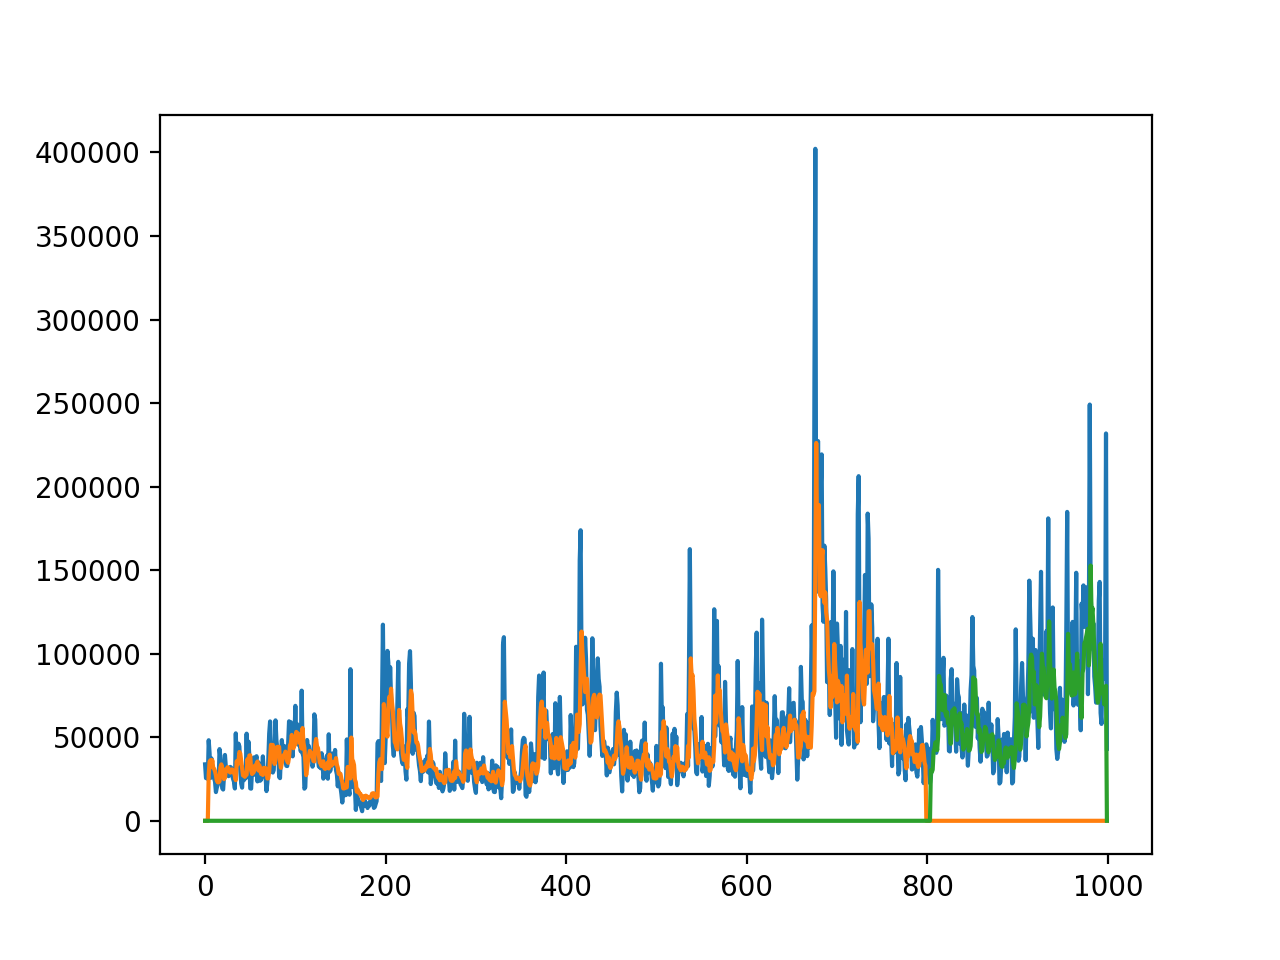

In [29]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data2)
#trainPredictPlot[:, :] = np.nan
trainPredictPlot[:, :] = 0
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data2)
#testPredictPlot[:, :] = np.nan
testPredictPlot[:, :] = 0
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data2)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [30]:
finalma = np.append(scaler.inverse_transform(data2).flatten(), trainPredictPlot.flatten())
finalma = np.append(finalma, testPredictPlot.flatten())

finallabels = np.append(["Original"]*len(trainPredictPlot), ["Train"]*len(trainPredictPlot))
finallabels = np.append(finallabels, ["Test"]*len(trainPredictPlot))

finaltime = np.append(range(len(trainPredictPlot)), range(len(trainPredictPlot)))
finaltime = np.append(finaltime, range(len(trainPredictPlot)))

results = pd.DataFrame(data = 
    {'timeindex': finaltime,
    'volume': finalma,
    'label': finallabels}
)

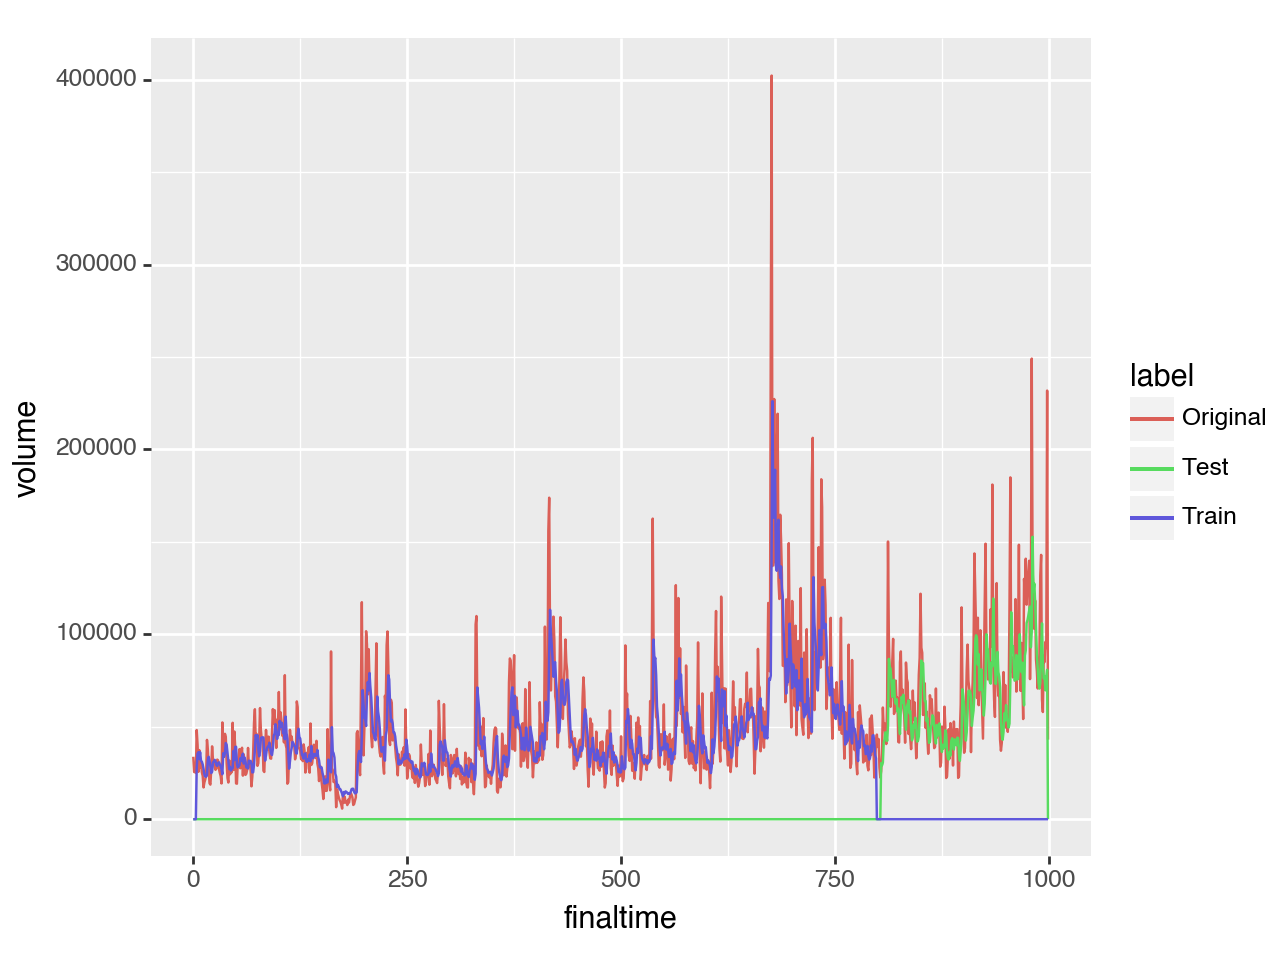

<Figure Size: (640 x 480)>

In [31]:
(ggplot(results, aes("finaltime", "volume", color = "label"))
 + geom_line())

### Conclusion

Among these 3 models, models 1 performed the best which has the lowerst RMSE 29878.04 in the test set. by comparing the graphs, model 1 also has the closest predicted values to actual values.